これから2つのtransformerモデルを使ってみる予定。（このファイルではDistilBERTだけ）  
### DistilBERT  
今回実装して学習まで行ってみるモデル  
bertに比べて軽く性能もある程度抑えているモデル。  
事前学習を使わず少ないデータで学習をさせるならDistilBERTで十分かもしれない
### TST(time series transformer)  
v21で実装予定  
時系列データに特化したTransformerモデルという説明だけ見つけた。  

使えるのかは分からないが、時系列データを扱ったモデルとしてTFT, Informer, Autoformer, PatchTST, ITransformerというのを見つけた。  
詳細はまだ調べ切れていないから使えるかどうかは分からない。  

transformerとは別だが、TCN(Temporal Convolutional Network)という時系列データを扱うために設計された畳み込みニューラルネットワークがあるみたい。  
CNNのところで実装する予定  
  
    
あとデータ拡張とかなんらかの方法を使ってクラスの偏りをなくす必要がある。  
このファイルでは実装できていない。

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertConfig
import seaborn as sns
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

#import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [3]:
fold = "../../train_raw_npy/"
acc_x = np.loadtxt("../../train_raw/Acc_x.txt")
label = np.load(f"{fold}sampled_label.npy")

print(acc_x.shape)
print(label.shape)


(196072, 500)
(196072,)


Max index after shifting: 30104
Vocab size: 30105
Sample discrete data: [[24029 24034 24075 ...  6255  7731  8392]
 [ 8839  8946  7772 ...  9095  9134  8994]
 [ 8474  7847  7012 ... 25182 25115 25278]
 ...
 [16043 14565 19002 ... 26111 21273  9221]
 [ 3849 12370 16115 ... 23046 24751 23873]
 [12795 12362 21437 ...  7500 12527 17853]]
Discrete data range: 104 to 30104


c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


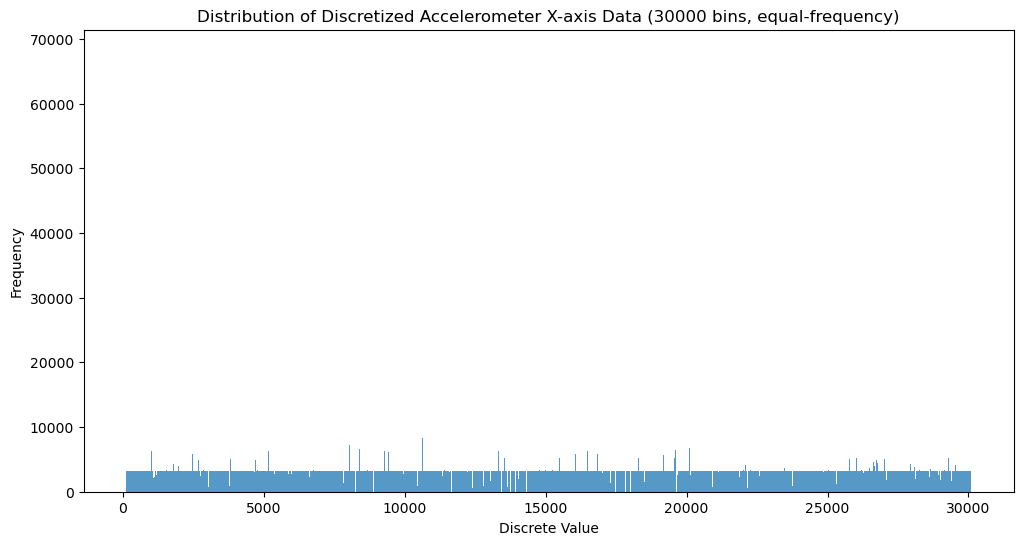

In [38]:
# ビンの数を設定
num_bins = 30000  

# ビンの境界を等頻度で設定
bins = np.percentile(acc_x, np.linspace(0, 100, num_bins + 1))

# データをビンに分割
discrete_data = np.digitize(acc_x, bins) - 1  # ビンのインデックスを取得し、0から始まるように調整

# 予約トークンを避けるためにシフト
discrete_data += 104

# 最大インデックスを確認
max_index = discrete_data.max()
print(f"Max index after shifting: {max_index}")

# vocab_sizeを確認（シフト後の最大値を考慮）
vocab_size = max_index + 1
print(f"Vocab size: {vocab_size}")

# 確認のための一部データ
print("Sample discrete data:", discrete_data[:10])
print("Discrete data range:", np.min(discrete_data), "to", np.max(discrete_data))

# 分布の視覚化
plt.figure(figsize=(12, 6))
sns.histplot(discrete_data.flatten(), bins=num_bins, kde=False)
plt.title(f"Distribution of Discretized Accelerometer X-axis Data ({num_bins} bins, equal-frequency)")
plt.xlabel("Discrete Value")
plt.ylabel("Frequency")
plt.show()

# 離散化されたデータを保存
#np.save("train_token_ids_rebinned.npy", discrete_data)


In [55]:
#説明変数
discrete_data
#目的変数
label

#おしり12万データを使う  
X_30000 = discrete_data[-130000:-10000,:]
label_30000 = label[-130000:-10000]
print(X_30000.shape)
print(label_30000.shape)

(120000, 500)
(120000,)


In [56]:
print(X_30000.dtype)
print(label_30000.dtype)
X_30000 =X_30000.astype(np.int32)
label_30000 = label_30000.astype(np.int32)
print(X_30000.dtype)
print(label_30000.dtype)

int64
float64
int32
int32


In [57]:
# ランダムサンプリング
train_x, test_x, train_label, test_label = train_test_split(X_30000, label_30000, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_x.shape}")
print(f"Test data shape: {test_x.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())

Train data shape: (96000, 500)
Test data shape: (24000, 500)
Train label shape: (96000,)
Test label shape: (24000,)
5    16476
6    14787
7    13453
1    12804
2    12488
8    11172
4    10568
3     4252
Name: count, dtype: int64
5    4201
6    3737
7    3332
1    3201
2    3125
8    2800
4    2597
3    1007
Name: count, dtype: int64


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class SensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx], dtype=torch.long)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        # [CLS] と [SEP] トークンを追加
        input_ids = torch.cat([torch.tensor([101]), input_ids, torch.tensor([102])])

        attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [58]:
# ラベルを0~7クラス分類とする
print(train_label)
train_label -=1
print(train_label)
print(test_label)
test_label -=1
print(test_label)

[5 7 5 ... 5 1 5]
[4 6 4 ... 4 0 4]
[8 4 8 ... 7 8 2]
[7 3 7 ... 6 7 1]


In [59]:
# データセットとデータローダの作成
train_dataset = SensorDataset(train_x, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_dataset = SensorDataset(test_x, test_label)
eval_dataloader = DataLoader(eval_dataset)

In [60]:
#DistilBERT
from transformers import DistilBertForSequenceClassification, DistilBertConfig

config = DistilBertConfig(
    vocab_size=vocab_size,
    num_labels=8,
)
model = DistilBertForSequenceClassification(config)

print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30105, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [61]:
# トレーニング設定
training_args = TrainingArguments(
    output_dir="./results_distilBERT",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=0,
    save_total_limit=None,
    #logging_dir = "./logs_distilBERT",
    evaluation_strategy="steps",
    eval_steps=1_000,
    logging_steps=100,
)

# トレーナーの定義
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# トレーニングの実行
trainer.train()

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/18000 [00:00<?, ?it/s]

{'loss': 2.0852, 'grad_norm': 4.558734893798828, 'learning_rate': 4.972222222222223e-05, 'epoch': 0.02}
{'loss': 2.0488, 'grad_norm': 3.1452324390411377, 'learning_rate': 4.9444444444444446e-05, 'epoch': 0.03}
{'loss': 1.9494, 'grad_norm': 4.0973920822143555, 'learning_rate': 4.9166666666666665e-05, 'epoch': 0.05}
{'loss': 1.7391, 'grad_norm': 3.8018808364868164, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.07}
{'loss': 1.6688, 'grad_norm': 5.376004695892334, 'learning_rate': 4.8611111111111115e-05, 'epoch': 0.08}
{'loss': 1.7165, 'grad_norm': 3.799398183822632, 'learning_rate': 4.8333333333333334e-05, 'epoch': 0.1}
{'loss': 1.5974, 'grad_norm': 5.40103006362915, 'learning_rate': 4.805555555555556e-05, 'epoch': 0.12}
{'loss': 1.5855, 'grad_norm': 4.454703330993652, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.13}
{'loss': 1.5623, 'grad_norm': 4.709499835968018, 'learning_rate': 4.75e-05, 'epoch': 0.15}
{'loss': 1.5209, 'grad_norm': 6.761170387268066, 'learning_rate': 4.722

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.6497939825057983, 'eval_runtime': 100.0942, 'eval_samples_per_second': 239.774, 'eval_steps_per_second': 29.972, 'epoch': 0.17}
{'loss': 1.5623, 'grad_norm': 4.5909423828125, 'learning_rate': 4.6944444444444446e-05, 'epoch': 0.18}
{'loss': 1.52, 'grad_norm': 3.9765942096710205, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.2}
{'loss': 1.5167, 'grad_norm': 5.6525559425354, 'learning_rate': 4.638888888888889e-05, 'epoch': 0.22}
{'loss': 1.4798, 'grad_norm': 5.014337062835693, 'learning_rate': 4.6111111111111115e-05, 'epoch': 0.23}
{'loss': 1.4617, 'grad_norm': 5.58466100692749, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.25}
{'loss': 1.4683, 'grad_norm': 4.098711967468262, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.27}
{'loss': 1.4834, 'grad_norm': 6.115455150604248, 'learning_rate': 4.527777777777778e-05, 'epoch': 0.28}
{'loss': 1.4698, 'grad_norm': 6.175425052642822, 'learning_rate': 4.5e-05, 'epoch': 0.3}
{'loss': 1.4234, 'grad_norm': 5.19547367095

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.4843653440475464, 'eval_runtime': 101.6067, 'eval_samples_per_second': 236.205, 'eval_steps_per_second': 29.526, 'epoch': 0.33}
{'loss': 1.4525, 'grad_norm': 4.984988212585449, 'learning_rate': 4.4166666666666665e-05, 'epoch': 0.35}
{'loss': 1.4774, 'grad_norm': 5.895725727081299, 'learning_rate': 4.388888888888889e-05, 'epoch': 0.37}
{'loss': 1.4136, 'grad_norm': 4.73805570602417, 'learning_rate': 4.3611111111111116e-05, 'epoch': 0.38}
{'loss': 1.4173, 'grad_norm': 5.07771110534668, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}
{'loss': 1.442, 'grad_norm': 6.356640338897705, 'learning_rate': 4.305555555555556e-05, 'epoch': 0.42}
{'loss': 1.4373, 'grad_norm': 4.454743385314941, 'learning_rate': 4.277777777777778e-05, 'epoch': 0.43}
{'loss': 1.46, 'grad_norm': 4.896822452545166, 'learning_rate': 4.25e-05, 'epoch': 0.45}
{'loss': 1.4489, 'grad_norm': 6.43097448348999, 'learning_rate': 4.222222222222222e-05, 'epoch': 0.47}
{'loss': 1.4345, 'grad_norm': 4.518579483

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.399621605873108, 'eval_runtime': 107.6707, 'eval_samples_per_second': 222.902, 'eval_steps_per_second': 27.863, 'epoch': 0.5}
{'loss': 1.4025, 'grad_norm': 6.329294204711914, 'learning_rate': 4.138888888888889e-05, 'epoch': 0.52}
{'loss': 1.3959, 'grad_norm': 6.470837116241455, 'learning_rate': 4.111111111111111e-05, 'epoch': 0.53}
{'loss': 1.4041, 'grad_norm': 6.242680072784424, 'learning_rate': 4.0833333333333334e-05, 'epoch': 0.55}
{'loss': 1.3913, 'grad_norm': 4.414731979370117, 'learning_rate': 4.055555555555556e-05, 'epoch': 0.57}
{'loss': 1.4028, 'grad_norm': 4.924964904785156, 'learning_rate': 4.027777777777778e-05, 'epoch': 0.58}
{'loss': 1.3853, 'grad_norm': 6.809503555297852, 'learning_rate': 4e-05, 'epoch': 0.6}
{'loss': 1.4049, 'grad_norm': 5.313435077667236, 'learning_rate': 3.972222222222222e-05, 'epoch': 0.62}
{'loss': 1.3902, 'grad_norm': 5.324738025665283, 'learning_rate': 3.944444444444445e-05, 'epoch': 0.63}
{'loss': 1.402, 'grad_norm': 7.06913757324

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.3767098188400269, 'eval_runtime': 107.7569, 'eval_samples_per_second': 222.723, 'eval_steps_per_second': 27.84, 'epoch': 0.67}
{'loss': 1.4407, 'grad_norm': 4.209206581115723, 'learning_rate': 3.8611111111111116e-05, 'epoch': 0.68}
{'loss': 1.4155, 'grad_norm': 4.862961769104004, 'learning_rate': 3.8333333333333334e-05, 'epoch': 0.7}
{'loss': 1.4074, 'grad_norm': 5.702841758728027, 'learning_rate': 3.805555555555555e-05, 'epoch': 0.72}
{'loss': 1.3636, 'grad_norm': 6.376826763153076, 'learning_rate': 3.777777777777778e-05, 'epoch': 0.73}
{'loss': 1.381, 'grad_norm': 3.8986058235168457, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.75}
{'loss': 1.3455, 'grad_norm': 4.8212714195251465, 'learning_rate': 3.722222222222222e-05, 'epoch': 0.77}
{'loss': 1.3742, 'grad_norm': 4.4183807373046875, 'learning_rate': 3.694444444444445e-05, 'epoch': 0.78}
{'loss': 1.3871, 'grad_norm': 6.829916477203369, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}
{'loss': 1.3222, 'gra

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.3529871702194214, 'eval_runtime': 108.0295, 'eval_samples_per_second': 222.162, 'eval_steps_per_second': 27.77, 'epoch': 0.83}
{'loss': 1.3585, 'grad_norm': 5.232393741607666, 'learning_rate': 3.5833333333333335e-05, 'epoch': 0.85}
{'loss': 1.3554, 'grad_norm': 8.659676551818848, 'learning_rate': 3.555555555555556e-05, 'epoch': 0.87}
{'loss': 1.3621, 'grad_norm': 5.8324480056762695, 'learning_rate': 3.527777777777778e-05, 'epoch': 0.88}
{'loss': 1.3506, 'grad_norm': 6.138405799865723, 'learning_rate': 3.5e-05, 'epoch': 0.9}
{'loss': 1.3916, 'grad_norm': 5.215143203735352, 'learning_rate': 3.472222222222222e-05, 'epoch': 0.92}
{'loss': 1.3524, 'grad_norm': 6.708757400512695, 'learning_rate': 3.444444444444445e-05, 'epoch': 0.93}
{'loss': 1.3656, 'grad_norm': 5.3544230461120605, 'learning_rate': 3.4166666666666666e-05, 'epoch': 0.95}
{'loss': 1.3774, 'grad_norm': 4.664383888244629, 'learning_rate': 3.388888888888889e-05, 'epoch': 0.97}
{'loss': 1.3651, 'grad_norm': 5.9668

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.3315125703811646, 'eval_runtime': 106.3055, 'eval_samples_per_second': 225.764, 'eval_steps_per_second': 28.221, 'epoch': 1.0}
{'loss': 1.2422, 'grad_norm': 7.579037189483643, 'learning_rate': 3.3055555555555553e-05, 'epoch': 1.02}
{'loss': 1.2745, 'grad_norm': 4.034688949584961, 'learning_rate': 3.277777777777778e-05, 'epoch': 1.03}
{'loss': 1.2676, 'grad_norm': 4.4558281898498535, 'learning_rate': 3.2500000000000004e-05, 'epoch': 1.05}
{'loss': 1.2753, 'grad_norm': 6.713953018188477, 'learning_rate': 3.222222222222223e-05, 'epoch': 1.07}
{'loss': 1.2329, 'grad_norm': 6.360020637512207, 'learning_rate': 3.194444444444444e-05, 'epoch': 1.08}
{'loss': 1.2489, 'grad_norm': 6.397701263427734, 'learning_rate': 3.1666666666666666e-05, 'epoch': 1.1}
{'loss': 1.2649, 'grad_norm': 5.18333101272583, 'learning_rate': 3.138888888888889e-05, 'epoch': 1.12}
{'loss': 1.1969, 'grad_norm': 5.088220119476318, 'learning_rate': 3.111111111111111e-05, 'epoch': 1.13}
{'loss': 1.2832, 'grad_

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.3424180746078491, 'eval_runtime': 108.0877, 'eval_samples_per_second': 222.042, 'eval_steps_per_second': 27.755, 'epoch': 1.17}
{'loss': 1.2304, 'grad_norm': 4.538482666015625, 'learning_rate': 3.0277777777777776e-05, 'epoch': 1.18}
{'loss': 1.2377, 'grad_norm': 4.624894618988037, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 1.2411, 'grad_norm': 5.375890731811523, 'learning_rate': 2.9722222222222223e-05, 'epoch': 1.22}
{'loss': 1.2272, 'grad_norm': 6.513454914093018, 'learning_rate': 2.9444444444444448e-05, 'epoch': 1.23}
{'loss': 1.2093, 'grad_norm': 4.190282821655273, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}
{'loss': 1.2331, 'grad_norm': 5.55300760269165, 'learning_rate': 2.8888888888888888e-05, 'epoch': 1.27}
{'loss': 1.2568, 'grad_norm': 6.171873569488525, 'learning_rate': 2.861111111111111e-05, 'epoch': 1.28}
{'loss': 1.2938, 'grad_norm': 7.255709171295166, 'learning_rate': 2.8333333333333335e-05, 'epoch': 1.3}
{'loss': 1.2472, 'grad_norm': 5.225685

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.3354511260986328, 'eval_runtime': 102.0659, 'eval_samples_per_second': 235.142, 'eval_steps_per_second': 29.393, 'epoch': 1.33}
{'loss': 1.2129, 'grad_norm': 5.822038173675537, 'learning_rate': 2.7500000000000004e-05, 'epoch': 1.35}
{'loss': 1.2602, 'grad_norm': 3.8443994522094727, 'learning_rate': 2.7222222222222223e-05, 'epoch': 1.37}
{'loss': 1.216, 'grad_norm': 7.14711856842041, 'learning_rate': 2.6944444444444445e-05, 'epoch': 1.38}
{'loss': 1.2304, 'grad_norm': 4.612793922424316, 'learning_rate': 2.6666666666666667e-05, 'epoch': 1.4}
{'loss': 1.2488, 'grad_norm': 4.578118324279785, 'learning_rate': 2.6388888888888892e-05, 'epoch': 1.42}
{'loss': 1.2228, 'grad_norm': 3.8985049724578857, 'learning_rate': 2.6111111111111114e-05, 'epoch': 1.43}
{'loss': 1.2273, 'grad_norm': 5.447657585144043, 'learning_rate': 2.5833333333333336e-05, 'epoch': 1.45}
{'loss': 1.1949, 'grad_norm': 5.865983486175537, 'learning_rate': 2.5555555555555554e-05, 'epoch': 1.47}
{'loss': 1.1811, 

  0%|          | 0/3000 [00:00<?, ?it/s]

{'eval_loss': 1.3529062271118164, 'eval_runtime': 102.8811, 'eval_samples_per_second': 233.279, 'eval_steps_per_second': 29.16, 'epoch': 1.5}
{'loss': 1.2049, 'grad_norm': 4.709597110748291, 'learning_rate': 2.4722222222222223e-05, 'epoch': 1.52}
{'loss': 1.1963, 'grad_norm': 6.063511848449707, 'learning_rate': 2.4444444444444445e-05, 'epoch': 1.53}
{'loss': 1.2625, 'grad_norm': 5.510810852050781, 'learning_rate': 2.4166666666666667e-05, 'epoch': 1.55}
{'loss': 1.2225, 'grad_norm': 5.222231388092041, 'learning_rate': 2.3888888888888892e-05, 'epoch': 1.57}
{'loss': 1.2115, 'grad_norm': 7.267528057098389, 'learning_rate': 2.361111111111111e-05, 'epoch': 1.58}
{'loss': 1.2247, 'grad_norm': 4.652585506439209, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}
{'loss': 1.2015, 'grad_norm': 4.973272323608398, 'learning_rate': 2.3055555555555558e-05, 'epoch': 1.62}
{'loss': 1.2213, 'grad_norm': 5.514471054077148, 'learning_rate': 2.277777777777778e-05, 'epoch': 1.63}
{'loss': 1.2016, 'gra

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [54]:
del model
del train_dataset
del trainer
del eval_dataset

import gc
gc.collect()
torch.cuda.empty_cache()

# 評価  
以下から学習したモデルの性能を見ていく  
様々なモデルの性能を上から並べてある。小見出しがモデルの説明　参考に

### 語彙数5105 バッチサイズ32 あとデフォルト

In [17]:
from sklearn.metrics import classification_report

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

  0%|          | 0/750 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.64      0.52      0.57      1041
           2       0.42      0.55      0.48       719
           3       0.98      0.95      0.96       243
           4       0.71      0.80      0.75       960
           5       0.46      0.53      0.49       774
           6       0.46      0.45      0.45       926
           7       0.46      0.49      0.47       964
           8       0.33      0.09      0.14       373

    accuracy                           0.54      6000
   macro avg       0.56      0.55      0.54      6000
weighted avg       0.54      0.54      0.54      6000



### 語彙数5105 バッチサイズ16　あとデフォルト  
ここから損失値のグラフも表示させる

  0%|          | 0/750 [00:00<?, ?it/s]

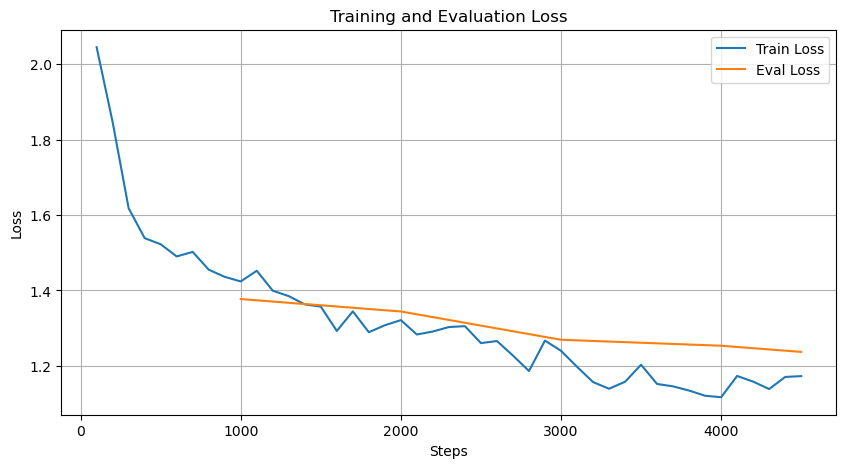

  0%|          | 0/750 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.66      0.49      0.56      1041
           2       0.43      0.53      0.47       719
           3       0.98      0.94      0.96       243
           4       0.71      0.80      0.75       960
           5       0.42      0.53      0.47       774
           6       0.48      0.40      0.43       926
           7       0.44      0.55      0.49       964
           8       0.33      0.09      0.14       373

    accuracy                           0.54      6000
   macro avg       0.56      0.54      0.54      6000
weighted avg       0.54      0.54      0.53      6000



In [26]:
from sklearn.metrics import classification_report

final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
eval_loss.append(final_evaluation["eval_loss"])
eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

### 語彙数10105(約2倍)  バッチサイズ16  あとデフォルト  
バッチサイズ32がvramが足りないから実行できない。（ローカルでの話）

  0%|          | 0/750 [00:00<?, ?it/s]

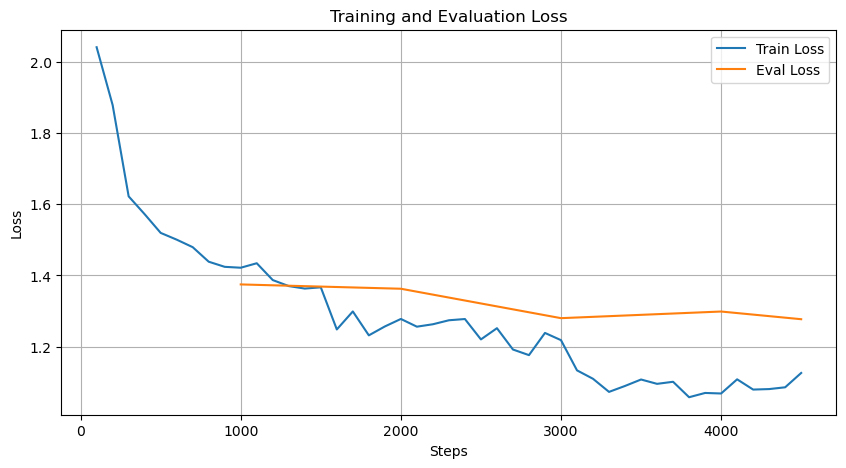

  0%|          | 0/750 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.62      0.60      0.61      1041
           2       0.39      0.61      0.47       719
           3       0.98      0.95      0.96       243
           4       0.76      0.72      0.74       960
           5       0.44      0.48      0.46       774
           6       0.47      0.38      0.42       926
           7       0.42      0.50      0.45       964
           8       0.00      0.00      0.00       373

    accuracy                           0.53      6000
   macro avg       0.51      0.53      0.52      6000
weighted avg       0.51      0.53      0.52      6000



c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.metrics import classification_report

final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
eval_loss.append(final_evaluation["eval_loss"])
eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

### 語彙数30105 バッチサイズ16　他デフォルト  
ここから混同行列も見てみる  
この語彙数はもとのdistilBertと同じくらいのサイズ（トークナイザーで変換されるトークン語彙数の数のこと）

  0%|          | 0/750 [00:00<?, ?it/s]

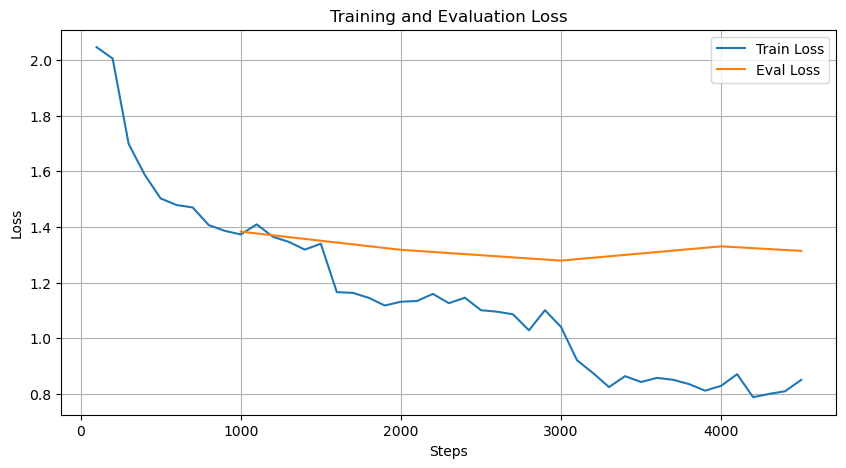

  0%|          | 0/750 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.66      0.63      0.65      1041
           2       0.37      0.56      0.44       719
           3       0.97      0.95      0.96       243
           4       0.79      0.63      0.70       960
           5       0.51      0.51      0.51       774
           6       0.44      0.50      0.47       926
           7       0.51      0.51      0.51       964
           8       0.36      0.10      0.16       373

    accuracy                           0.55      6000
   macro avg       0.58      0.55      0.55      6000
weighted avg       0.56      0.55      0.55      6000



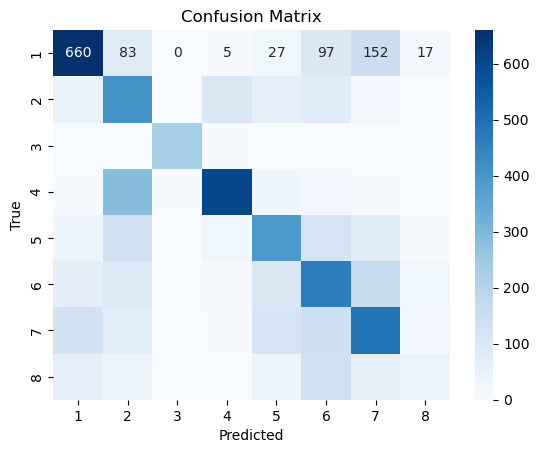

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
eval_loss.append(final_evaluation["eval_loss"])
eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
#true_labels = eval_dataset["labels"]
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1,9)], yticklabels=[str(i) for i in range(1,9)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### データ4倍　語彙数30105　バッチサイズ16 他デフォルト  
多分データのとり方が悪い。  
ランダムにデータを取っていないからよくないのかも

{'eval_loss': 1.341773271560669, 'eval_runtime': 102.1402, 'eval_samples_per_second': 234.971, 'eval_steps_per_second': 29.371, 'epoch': 1.67}


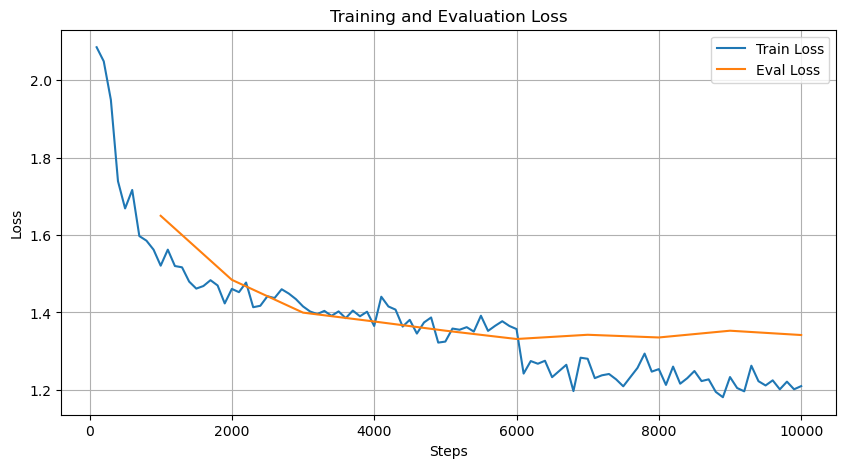

  0%|          | 0/3000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.49      0.66      0.57      3201
           2       0.52      0.51      0.52      3125
           3       0.85      0.86      0.85      1007
           4       0.67      0.63      0.65      2597
           5       0.45      0.70      0.55      4201
           6       0.50      0.29      0.37      3737
           7       0.38      0.42      0.40      3332
           8       0.27      0.08      0.12      2800

    accuracy                           0.49     24000
   macro avg       0.52      0.52      0.50     24000
weighted avg       0.48      0.49      0.47     24000



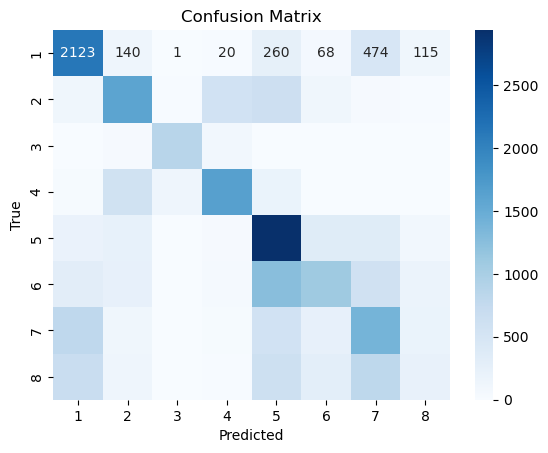

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
eval_loss.append(final_evaluation["eval_loss"])
eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
#true_labels = eval_dataset["labels"]
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1,9)], yticklabels=[str(i) for i in range(1,9)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
